In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", filename="steam.txt")


('steam.txt', <http.client.HTTPMessage at 0x7f87d5b31240>)

In [4]:
total_data = pd.read_table('steam.txt', names=['label', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력
total_data[:5]

#중복제거
total_data['reviews'].nunique(), total_data['label'].nunique()

total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))

print('isHaveNullValue? ',total_data.isnull().values.any())


전체 리뷰 개수 : 100000
총 샘플의 수 : 99892
isHaveNullValue?  False


훈련용 리뷰의 개수 : 74919
테스트용 리뷰의 개수 : 24973
   label  count
0      0  37376
1      1  37543


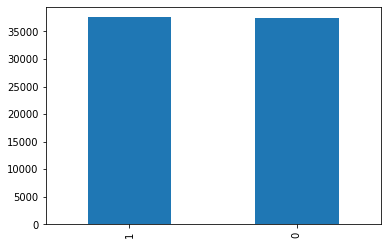

In [5]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

train_data['label'].value_counts().plot(kind = 'bar')
print(train_data.groupby('label').size().reset_index(name = 'count'))


In [6]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

label      0
reviews    0
dtype: int64


/Users/esens/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/esens/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [7]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 24973


/Users/esens/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/esens/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/esens/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:

In [8]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']

In [9]:
mecab = Mecab() 

train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

/Users/esens/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/esens/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [10]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

negative_word_count = Counter(negative_words)
print('===========Negative===========')
print(negative_word_count.most_common(20))

print('============Positive===========')
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

===========Negative===========
[('안', 8125), ('없', 7141), ('는데', 5729), ('있', 5690), ('같', 4251), ('로', 4171), ('할', 3931), ('거', 3903), ('나', 3818), ('해', 3650), ('너무', 3521), ('으로', 3351), ('기', 3350), ('했', 3262), ('어', 3155), ('습니다', 2962), ('지만', 2951), ('것', 2937), ('겠', 2901), ('않', 2898)]
============Positive===========
[('있', 9985), ('좋', 6540), ('습니다', 5178), ('재밌', 4997), ('지만', 4870), ('할', 4855), ('해', 4357), ('없', 4149), ('로', 3931), ('으로', 3900), ('수', 3836), ('보', 3832), ('는데', 3767), ('기', 3591), ('안', 3374), ('것', 3367), ('같', 3356), ('네요', 3189), ('어', 3123), ('나', 3080)]


긍정 리뷰의 평균 길이 : 14.947979650001331
부정 리뷰의 평균 길이 : 15.284701412671232


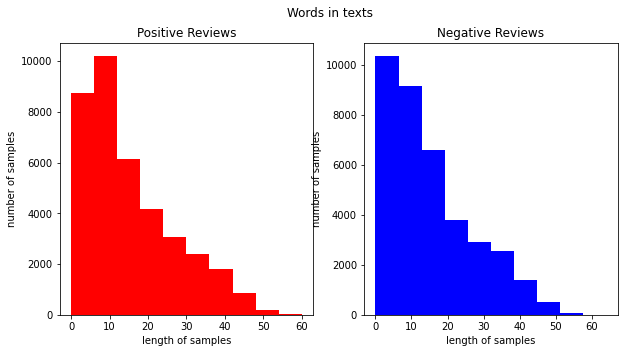

In [11]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [20]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32920
등장 빈도가 1번 이하인 희귀 단어의 수: 13905
단어 집합에서 희귀 단어의 비율: 42.23876063183475
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.227843842634659


In [21]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19017


In [22]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)



In [24]:

print(X_train[:3])
print(X_test[:3])

[[469, 635, 7, 35, 86, 149, 2417, 600, 26, 8, 70, 47, 233, 110, 38, 43, 52], [160, 300, 18, 21, 63, 3577, 985, 6, 56], [7, 16, 1477, 4]]
[[729, 34, 15, 433, 52, 106, 132, 88, 6459, 457], [4518, 689, 832, 713, 687, 109, 4, 1782, 98, 371, 3515, 81, 559, 1903, 4309, 261, 168, 61, 25, 364, 35, 86, 977, 19, 6292, 6417], [1728, 793, 567, 49, 23, 349]]


리뷰의 최대 길이 : 64
리뷰의 평균 길이 : 15.11596524246186


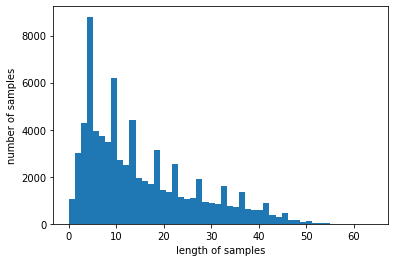

In [25]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [26]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [27]:
max_len = 60
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 99.99733045021956


In [28]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [29]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [30]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation='sigmoid'))

In [31]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [32]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/15
235/235 [==============================] - ETA: 0s - loss: 0.5155 - acc: 0.7466
Epoch 00001: val_acc improved from -inf to 0.78510, saving model to best_model.h5
235/235 [==============================] - 68s 291ms/step - loss: 0.5155 - acc: 0.7466 - val_loss: 0.4640 - val_acc: 0.7851
Epoch 2/15
235/235 [==============================] - ETA: 0s - loss: 0.4317 - acc: 0.8029
Epoch 00002: val_acc did not improve from 0.78510
235/235 [==============================] - 66s 282ms/step - loss: 0.4317 - acc: 0.8029 - val_loss: 0.5131 - val_acc: 0.7658
Epoch 3/15
235/235 [==============================] - ETA: 0s - loss: 0.4057 - acc: 0.8197
Epoch 00003: val_acc did not improve from 0.78510
235/235 [==============================] - 67s 285ms/step - loss: 0.4057 - acc: 0.8197 - val_loss: 0.4671 - val_acc: 0.7832
Epoch 4/15
235/235 [==============================] - ETA: 0s - loss: 0.3861 - acc: 0.8304
Epoch 00004: val_acc improved from 0.78510 to 0.78791, saving model to best_model.

In [33]:
loaded_model = load_model('best_model.h5')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

781/781 [==============================] - 11s 14ms/step - loss: 0.4578 - acc: 0.7868
테스트 정확도: 0.7868


In [34]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [36]:
sentiment_predict('노잼 ..완전 재미 없음 ㅉㅉ')
sentiment_predict('조금 어렵지만 재밌음ㅋㅋ')
sentiment_predict('씹오덕겜')
sentiment_predict('많이해보진않았지만 아직까진 할만한거같아요')
sentiment_predict('오타쿠')

95.00% 확률로 부정 리뷰입니다.
97.15% 확률로 긍정 리뷰입니다.
50.51% 확률로 부정 리뷰입니다.
82.83% 확률로 긍정 리뷰입니다.
68.42% 확률로 부정 리뷰입니다.
